<img style="float: right; margin: 0px 0px 15px 15px;" src="https://educationusa.state.gov/sites/default/files/wysiwyg/iteso_logo.jpg" width="520px" height="230px" />

# <span style="color: darkblue; ">Advanced Trading Strategies: _Deep Learning_</span>
`MICROSTRUCTURE AND TRADING SYSTEMS`

Juan Ramón Rocha López 

- Exp: 779950

Mariana Valenzuela Lafarga
    
- Exp: 749770

Repository on GitHub: [Link del repositorio](https://github.com/RaemonRoch/algo-trading)

### Strategy Overview

Strategy Overview: MLP and CNN for Trading Signal Prediction
1. Deep Learning Approach to Trading Signal Prediction

    The Deep Learning (DL) approach to trading signal prediction is based on using multi-layered neural networks to identify complex and non-linear patterns in financial market data.

    Unlike traditional statistical models (such as moving averages), which are based on predefined rules, DL models learn directly from historical data (such as prices, volumes, and technical indicators). The objective is for the model to "discover" subtle, dynamic, short- and long-term relationships.

    In this project, the DL model does not attempt to predict the exact price but rather generates a trading signal (e.g., "Long," "Short"). The model is trained to map a set of inputs (Features) to an optimal trading action, theoretically maximizing the classification accuracy of upward and downward price movements.

2. Rationale for Multiple Architectures (MLP & CNN)

    The decision to use both Multilayer Perceptrons (MLP) and Convolutional Neural Networks (CNN) is strategic and based on the diversity of information that each architecture can capture.

    * MLP (Multilayer Perceptron):

    Purpose: MLPs are excellent at finding relationships in structured or tabular data.

    Application: In this project, the MLP is primarily fed a set of pre-calculated technical indicators (such as RSI, MACD, Bollinger Bands, volatility). The MLP learns how combinations of these indicators correlate with future price movements. It acts as a "generalist" that seeks relationships between already-defined features.

    * CNN (Convolutional Neural Network):

    Purpose: CNNs are experts at extracting features from data with spatial or sequential structure, suchas images.

    Application: Instead of being fed indicators, the CNN treats market data (e.g., a 20-day window of Open, High, Low, and Close prices) as if it were a 1D or 2D "image." The CNN uses its filters to automatically detect local patterns without needing us to define them. It acts as an "automatic pattern extractor" directly from the price action.

    **Synergy**: By using both, the strategy does not rely on a single type of analysis. The MLP looks for patterns in the indicators, while the CNN looks for patterns in the pure price action. The hypothesis is that combining both signals (either in a hybrid model or as an ensemble) will provide a more robust and reliable trading signal.

3. Expected Advantages and Limitations
    Expected Advantages

    - Complex Pattern Detection: The ability to model non-linear relationships that traditional econometric models cannot capture.

    - Automatic Feature Extraction (CNN): The CNN reduces the need for manual "feature engineering," as it learns relevant patterns directly from the price data.

    - Robustness through Model Diversification: By combining two different architectures (MLP and CNN), the strategy is expected to reduce false signals.

    - Adaptability: DL models can, in theory, adapt to changing market conditions.

    Limitations and Challenges

    - Risk of Overfitting: This is the greatest limitation. The models may "memorize" random noise from historical data instead of learning the underlying pattern. If this occurs, the model will perform perfectly in the backtest but fail spectacularly in live trading.

    - "Black Box" Nature: It is often difficult or impossible to know why the neural network made a "Buy" or "Sell" decision. This lack of interpretability makes risk management and trusting the model difficult.

    - Non-Stationarity of Markets: Financial markets are constantly changing (regime changes, unforeseen events). A pattern that was profitable in the past may cease to be so. The model must be constantly monitored and retrained.

### Feature Engineering

The selection of these 29 features was designed to provide the models (MLP and CNN) with a multidimensional and comprehensive view of the market state, which is essential for a classification task (predicting upward and downward movements).

The features can be grouped into six key categories:

1. Raw Market Data (OHLCV): open, high, low, close, volume btc, volume usdt, and tradecount. This is the foundation of price action and liquidity. The CNN, in particular, will use this data to find visual patterns, while the MLP will use them as primary indicators.

2. Volume Indicators: (volume_adi, volume_obv, volume_cmf...). Price alone can be misleading. These indicators are crucial for measuring the conviction or strength behind a price move. They help us validate whether an upward or downward move has real capital flow supporting it.

3. Volatility Indicators: (volatility_bbli, volatility_kcc...). These indicators (like Keltner Channels and Bollinger Bands) define the current market regime. They help the model understand if the market is trending or ranging and identify overextended (breakout) or reversal conditions.

4. Trend Indicators: (trend_visual_ichimoku_a, trend_aroon_up/down, trend_psar...). Since the goal is to classify direction, these indicators are fundamental. They provide explicit confirmation of the direction, strength, and duration of the current trend.

5. Momentum Indicators: (momentum_stoch, momentum_stoch_signal). Momentum measures the velocity of price change. It is vital for identifying overbought or oversold conditions, which often precede a turn in price (a change in classification).

6. Temporal Features: (month, day, hour). Markets often exhibit cyclical or seasonal patterns (e.g., higher volatility at certain hours or days). These features allow the model to capture any time-based anomalies or patterns.

### Target Variable Definition

For this project, the objective is not to predict the exact price (a regression problem), but rather to predict the direction of the price movement in the next time period (a classification problem).

The target variable is a binary (categorical) variable defined as follows:

- Class 1 (Up): The closing price of the next period (Close[t+1]) is greater than the closing price of the current period (Close[t]).

- Class 0 (Down): The closing price of the next period (Close[t+1]) is less than or equal to the closing price of the current period (Close[t]).

This classification approach was chosen because financial markets are inherently "noisy" (volatile and stochastic), which makes predicting the exact magnitude of a return extremely difficult and error-prone.

Instead, training the models to focus solely on the direction (up or down) has shown to yield better performance. This directional signal is, ultimately, the core information needed to execute a trading strategy (taking a "Long" or "Short" position).

### Model Architecture and Design

MLP: For the multilayer perceptron we implement the following structure:
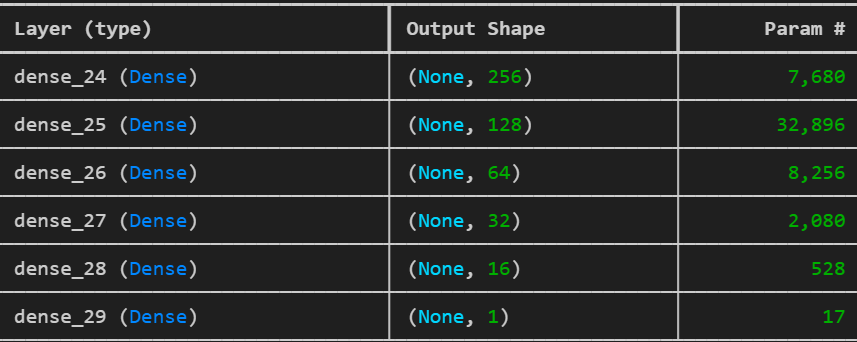

CNN:We implement the following structure for our convolutional network
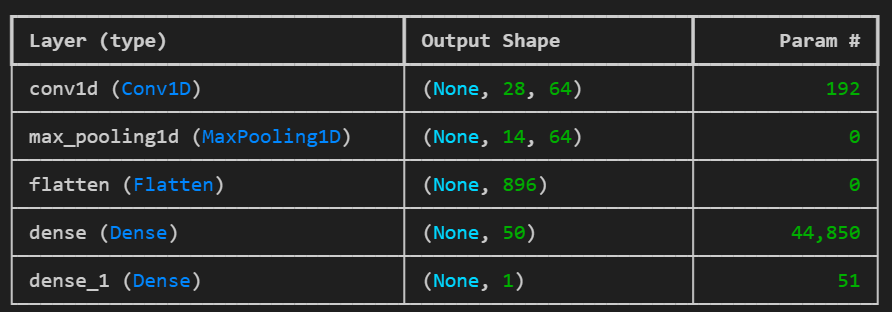

### MLFlow Experiment Tracking

We decided to use the factory pattern to facilitate training and tracking. When training each model, we run an experiment and store the model's metrics and weights.

Example:
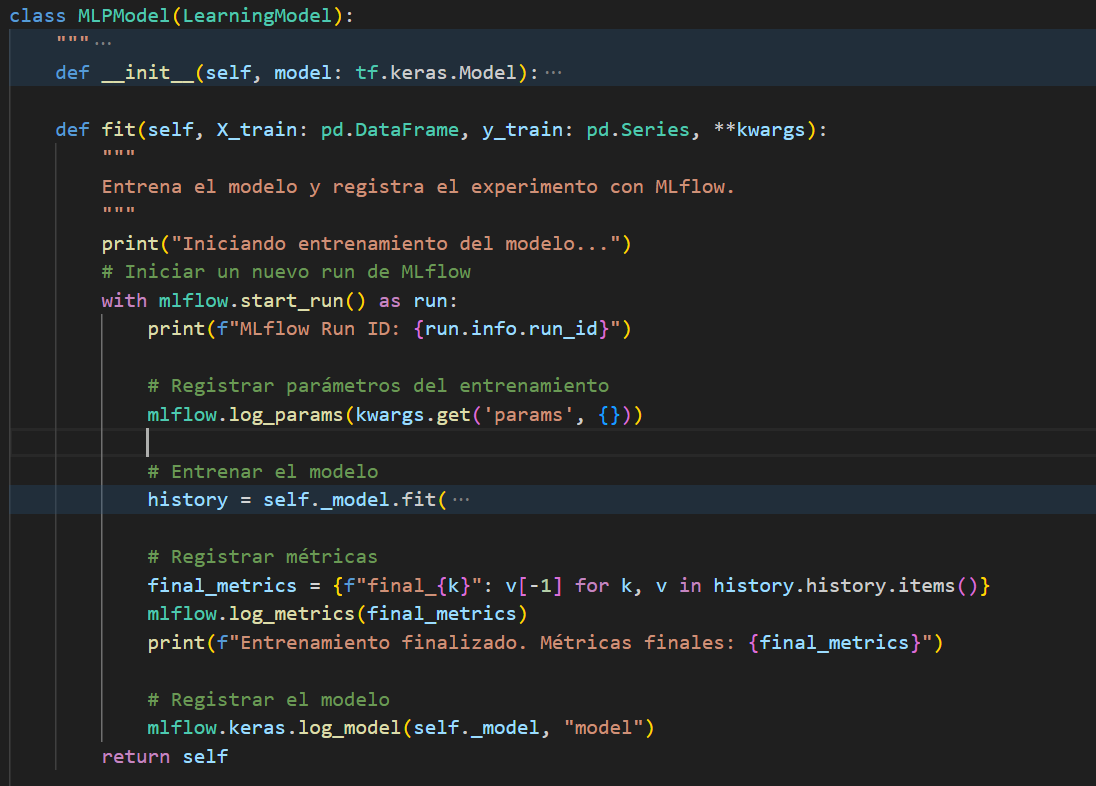


### Backtesting Methodology

The BackTesting module implements a robust system for evaluating the performance of algorithmic trading strategies using K-Fold Cross-Validation, specifically designed for time series.

The goal is to overcome the limitations of a single train/test split, evaluating the consistency and profitability of the strategy across multiple, independent market segments.

* Sequential Partitioning: The core of the system uses sklearn.model_selection.KFold with the parameter shuffle=False. This divides the historical dataset into K sequential and contiguous segments ("folds"), preserving the chronological order essential for financial analysis.

* Sequential Partitioning: The core of the system uses sklearn.model_selection.KFold with the parameter shuffle=False. This divides the historical dataset into K sequential and contiguous segments ("folds"), preserving the chronological order essential for financial analysis.

* Test Isolation (Key Technical Detail): To ensure statistical validity, the simulation state is completely reset before each fold. This is achieved by creating a deep copy (copy.deepcopy) of the initial Exchange object. This step is critical because it ensures that each fold runs as an independent experiment, starting with the same initial capital and with no "memory" of previous trades.

The run_backtest method iterates over each of the K folds, running the strategy only on the data in that segment. The performance of each run (the portfolio's value history) is stored independently.

The end result is a set of K performance simulations. This allows for a comprehensive statistical analysis of the strategy, including its average performance, standard deviation, and consistency across different market conditions, providing a much more reliable evaluation than a single backtest.

### Results and Performance Analysis

As described in the Backtesting Methodology, the strategy was rigorously evaluated using K-Fold Cross-Validation (K=5) on sequential market segments. The objective was to test the model's (MLP/CNN) consistency and robustness rather than relying on a single backtest result.

The results of these 5 independent simulations are presented in the "Portfolio Performance by Fold" chart. Each fold represents a distinct time period, and the simulation in each begins with the same initial capital (in this case, $1,000,000).

Key Observations:

- High Inconsistency Across Folds: The most critical observation is the extreme variability in performance across the different folds. The strategy's performance is highly dependent on the time segment (or market regime) in which it is tested.

- Mixed Performance:

    Fold 1 and 4: These show significant losses, indicating the strategy fails under the market conditions of those periods (approx. July and late August 2025).

    Fold 2 and 3: These show performance close to breakeven, with considerable volatility.

    Fold 5: This is the only fold that shows significant positive profitability (approx. September 2025).

Interpretation Analysis:

This stark inconsistency suggests that the strategy, in its current form, is not robust and does not generalize well across all market conditions. It is likely that the patterns learned by the models (MLP/CNN) are not universal but are instead specific to certain market behaviors that were only present in Fold 5.

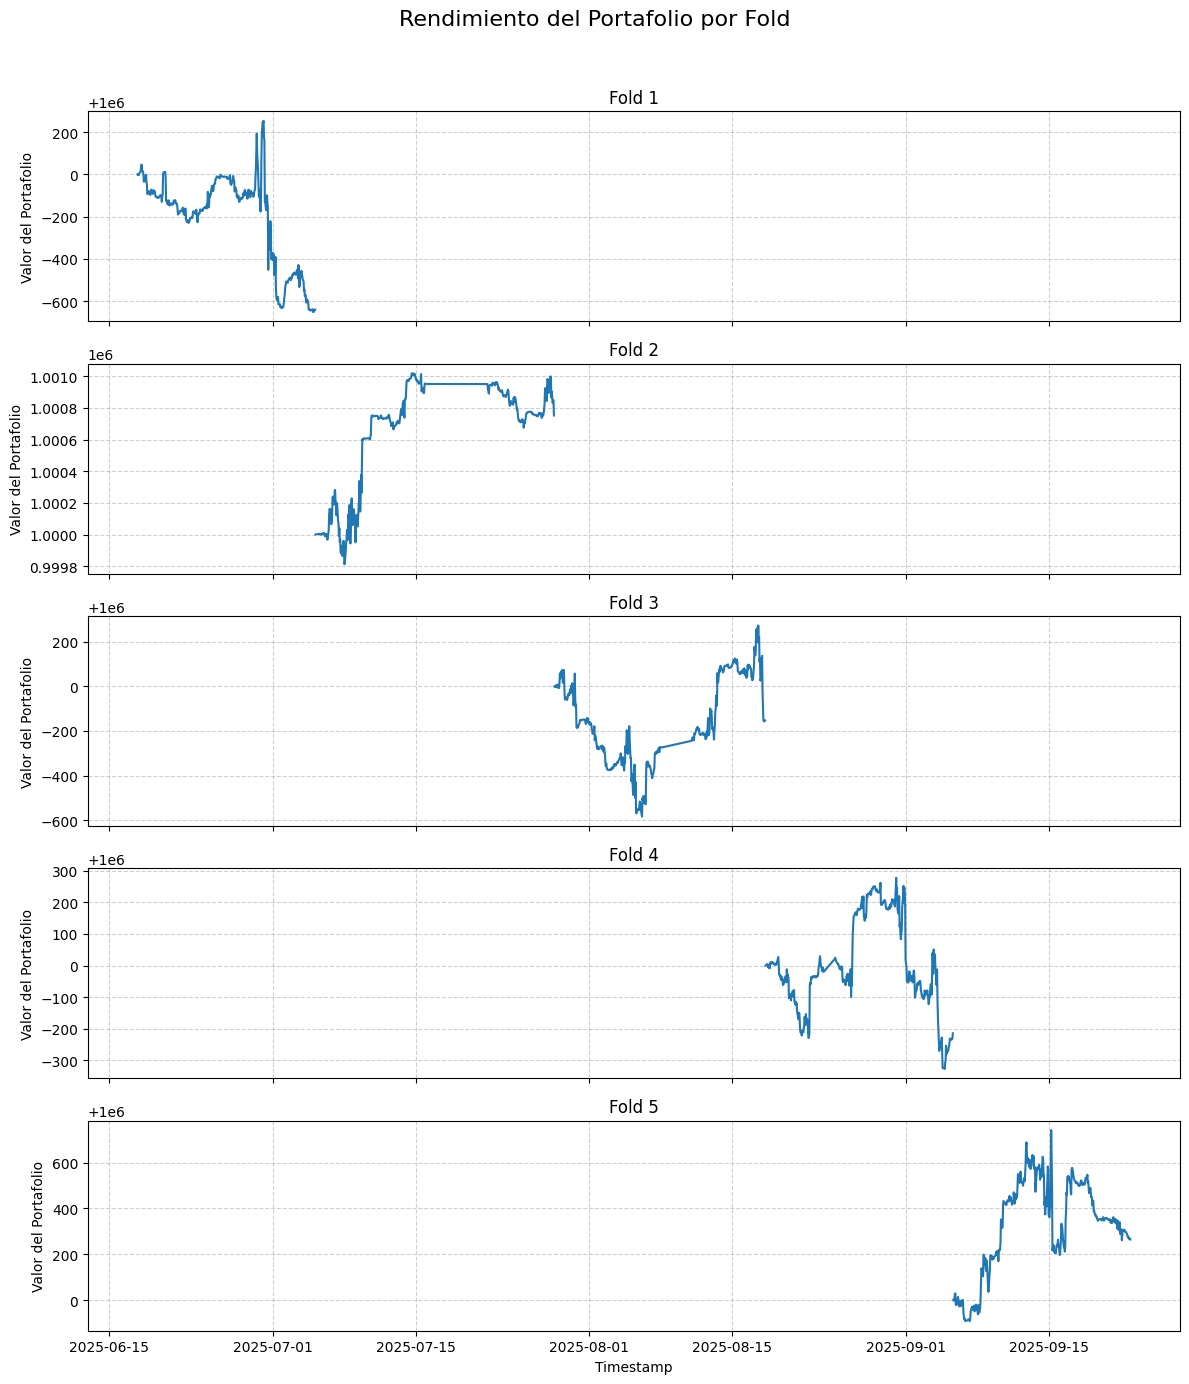

### Conclusions

This project evaluated a hybrid (MLP and CNN) trading strategy designed to classify market direction. Validation was performed using K-Fold Cross-Validation (K=5) on sequential data segments to measure model consistency.

The results analysis revealed variable performance across the folds. Notable profitability was observed in one fold (Fold 5), while the remaining folds (1-4) showed neutral or negative results.

This variability indicates that the model's performance is highly dependent on specific market conditions (regime-sensitive) and that its ability to generalize is limited.

While the profitability in one fold is promising, the lack of consistency suggests that further work on feature selection and regularization is required to develop a robust model applicable to a broader spectrum of market conditions.